# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [3]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [3]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [4]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 99: 100%|██████████| 430/430 [00:03<00:00, 122.50it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.957     0.973     0.965       980
           1      0.977     0.984     0.981      1135
           2      0.949     0.948     0.948      1032
           3      0.944     0.943     0.944      1010
           4      0.942     0.951     0.946       982
           5      0.947     0.945     0.946       892
           6      0.955     0.965     0.960       958
           7      0.946     0.951     0.949      1028
           8      0.949     0.931     0.940       974
           9      0.946     0.920     0.933      1009

    accuracy                          0.952     10000
   macro avg      0.951     0.951     0.951     10000
weighted avg      0.951     0.952     0.951     10000



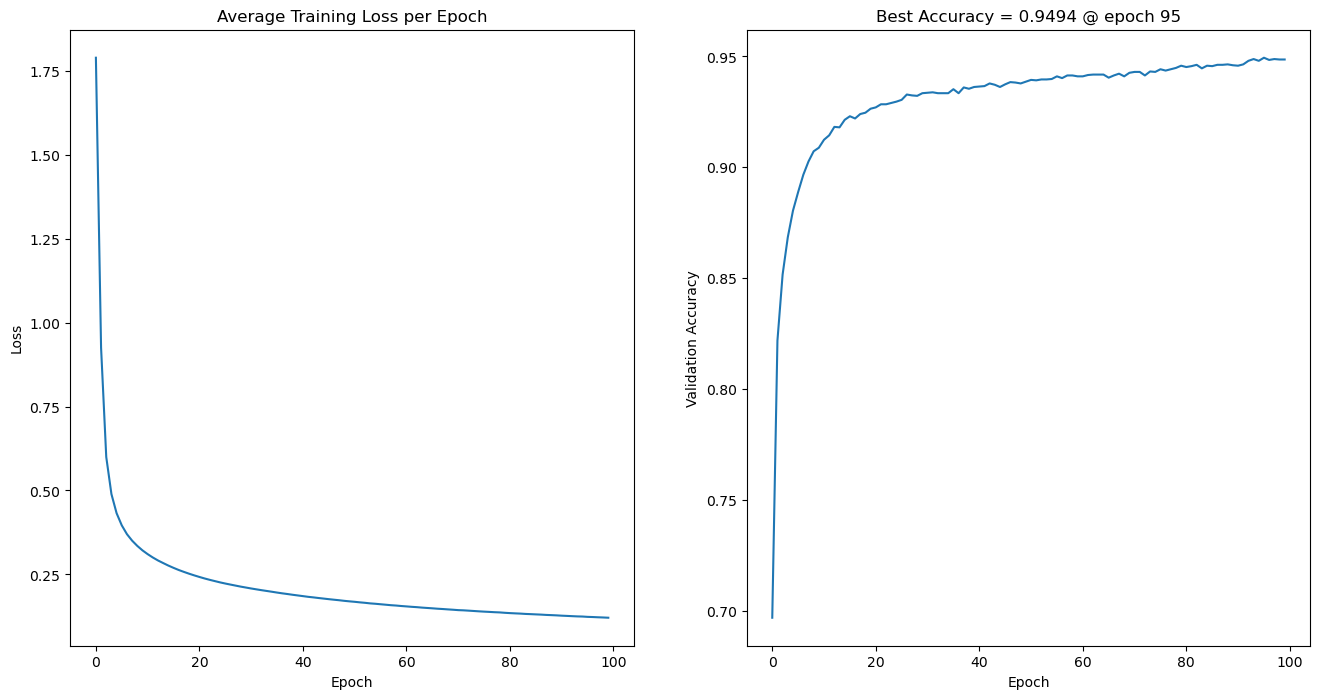

In [5]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 100
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 128
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
dl_val   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False, num_workers=4)
dl_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False, num_workers=4)

In [4]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=28*28, hidden1=128, hidden2=64, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

In [5]:
def train_one_epoch(model, dl, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return running_loss / total, correct / total

In [6]:
def evaluate(model, dl, device):
    model.eval()
    running_loss = 0.0
    preds_all = []
    gts_all = []
    with torch.no_grad():
        for x, y in dl:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits, y, reduction='sum')
            running_loss += loss.item()
            preds_all.append(logits.argmax(dim=1).cpu().numpy())
            gts_all.append(y.cpu().numpy())
    preds_all = np.hstack(preds_all)
    gts_all = np.hstack(gts_all)
    return running_loss / len(gts_all), accuracy_score(gts_all, preds_all), classification_report(gts_all, preds_all, zero_division=0, digits=3)

In [8]:
model = SimpleMLP(hidden1=128, hidden2=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
best_state = None

wandb.init(project="Lab-1", config={
"epochs": epochs,
"lr": 1e-3,
"batch_size": batch_size,
"model": "SimpleMLP"
})
config = wandb.config

for ep in range(1, epochs+1):
    train_loss, train_acc = train_one_epoch(model, dl_train, optimizer, device)
    val_loss, val_acc, _ = evaluate(model, dl_val, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc
    }, step=ep)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
    print(f"Epoch {ep:02d}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

artifact = wandb.Artifact("simple-mlp", type="model")
artifact.add_file("best_model.pth")
wandb.log_artifact(artifact)
best_state = model.state_dict()

wandb: Currently logged in as: matteo-piras (matteo-piras-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 01: train_loss=0.3480 train_acc=0.9004 | val_loss=0.2000 val_acc=0.9396
Epoch 02: train_loss=0.1462 train_acc=0.9564 | val_loss=0.1458 val_acc=0.9568
Epoch 03: train_loss=0.1013 train_acc=0.9692 | val_loss=0.1141 val_acc=0.9650
Epoch 04: train_loss=0.0752 train_acc=0.9769 | val_loss=0.1165 val_acc=0.9658
Epoch 05: train_loss=0.0584 train_acc=0.9820 | val_loss=0.0939 val_acc=0.9734
Epoch 06: train_loss=0.0489 train_acc=0.9845 | val_loss=0.0925 val_acc=0.9742
Epoch 07: train_loss=0.0378 train_acc=0.9877 | val_loss=0.1183 val_acc=0.9670
Epoch 08: train_loss=0.0323 train_acc=0.9892 | val_loss=0.1053 val_acc=0.9698
Epoch 09: train_loss=0.0264 train_acc=0.9911 | val_loss=0.1076 val_acc=0.9726
Epoch 10: train_loss=0.0225 train_acc=0.9926 | val_loss=0.1141 val_acc=0.9722
Epoch 11: train_loss=0.0197 train_acc=0.9935 | val_loss=0.1123 val_acc=0.9742
Epoch 12: train_loss=0.0176 train_acc=0.9942 | val_loss=0.1163 val_acc=0.9746
Epoch 13: train_loss=0.0169 train_acc=0.9944 | val_loss=0.1235 v

In [9]:
if best_state is not None:
    model.load_state_dict(best_state)


# Final test evaluation
test_loss, test_acc, test_report = evaluate(model, dl_test, device)
wandb.log({"test_loss": test_loss, "test_acc": test_acc})
wandb.log({"classification_report": str(test_report)})
wandb.finish()
print(f"Test loss: {test_loss:.4f}  Test acc: {test_acc:.4f}")
print("Classification report on TEST:\n", test_report)

test_acc,▁
test_loss,▁
train_accuracy,▁▅▆▇▇▇▇▇████████████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆██▆▇▇▇████▇▇████
val_loss,█▄▂▃▁▁▃▂▂▂▂▃▃▄▄▄▄▄▅▅
classification_report,precis...
test_acc,0.978
test_loss,0.1148
train_accuracy,0.99678
train_loss,0.00903


Test loss: 0.1148  Test acc: 0.9780
Classification report on TEST:
               precision    recall  f1-score   support

           0      0.984     0.988     0.986       980
           1      0.989     0.994     0.992      1135
           2      0.962     0.988     0.975      1032
           3      0.967     0.983     0.975      1010
           4      0.970     0.986     0.978       982
           5      0.978     0.964     0.971       892
           6      0.980     0.974     0.977       958
           7      0.982     0.975     0.979      1028
           8      0.985     0.959     0.972       974
           9      0.982     0.965     0.974      1009

    accuracy                          0.978     10000
   macro avg      0.978     0.978     0.978     10000
weighted avg      0.978     0.978     0.978     10000



### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [7]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

#### Residual MLP Block Overview

This block is a **flexible MLP version of a ResNet block**:

- Supports **one or multiple linear layers**.
- Handles **dimension changes** via a **projection** in the skip connection.
- During the construction of the `Sequential` block, it **skips the ReLU after the last layer**:
  - Ensures the **final ReLU is applied after adding the residual connection**, consistent with standard ResNet design.
- Allows **disabling the skip connection**, producing an **identical architecture without residuals** for clean comparisons.



In [8]:
#Code genrated by AI
class MLPBlock(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_layers=1, use_skip=True):
        super().__init__()
        self.use_skip = use_skip

        # Skip connection projection (if needed)
        if use_skip:
            self.proj = nn.Linear(dim_in, dim_out) if dim_in != dim_out else nn.Identity()

        # Build MLP layers
        layers = [nn.Linear(dim_in, dim_out)]
        for _ in range(hidden_layers - 2):
            layers.append(nn.Linear(dim_out, dim_out))
        if hidden_layers > 1:
            layers.append(nn.Linear(dim_out, dim_out))

        self.net = nn.Sequential(*[
            nn.Sequential(l, nn.ReLU(inplace=True)) if i < hidden_layers - 1 else l
            for i, l in enumerate(layers)
        ])
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.net(x)
        if self.use_skip:
            skip = self.proj(x)
            return self.relu(out + skip)
        else:
            return self.relu(out)

As a personal reminder, this code:  
```python
self.net = nn.Sequential(*[
    nn.Sequential(l, nn.ReLU(inplace=True)) if i < hidden_layers - 1 else l
    for i, l in enumerate(layers)
])
```
is the compact version of this code:
```python
layers_with_activation = []

# Loop through all layers
for i, layer in enumerate(layers):

    # If this is NOT the last layer → add ReLU after it
    if i < hidden_layers - 1:
        block = nn.Sequential(
            layer,
            nn.ReLU(inplace=True)
        )
    else:
        # Last layer: no activation
        block = layer

    layers_with_activation.append(block)

# Build nn.Sequential using unpacking
self.net = nn.Sequential(*layers_with_activation)
```

#### General MLP Overview

This class implements a **fully connected neural network (MLP)** with a flexible architecture:

- Composed of a **sequence of `MLPBlock`s**, each of which can optionally use **residual skip connections**.  
- **Layer sizes are fully configurable** via the `layer_sizes` list, e.g., `[input, hidden1, ..., output]`.  
- Supports **multiple hidden layers per block** using the `block_hidden_layers` parameter.  
- Automatically **flattens input** before feeding it into the MLP blocks.  
- Ends with a **linear classifier** mapping the final hidden representation to the output dimension.  
- Can create **identical architectures with or without residuals** for easy comparisons.


In [9]:
#Code genrated by AI
class GeneralMLP(nn.Module):
    def __init__(self, layer_sizes, block_hidden_layers=1, use_skip=True):
        super().__init__()
        self.flatten = nn.Flatten()
        blocks = []
        for nin, nout in zip(layer_sizes[:-2], layer_sizes[1:-1]):
            blocks.append(MLPBlock(nin, nout, hidden_layers=block_hidden_layers, use_skip=use_skip))
        self.blocks = nn.Sequential(*blocks) if blocks else nn.Identity()
        last_hidden = layer_sizes[-2] if len(layer_sizes) >= 2 else layer_sizes[0]
        self.classifier = nn.Linear(last_hidden, layer_sizes[-1])

    def forward(self, x):
        x = self.flatten(x)
        x = self.blocks(x)
        return self.classifier(x)

#### Comparing three different configurations 2, 4 and 8 residual vs non-residual blocks

In [22]:

config = {
    "batch_size": 128,
    "lr": 0.01,
    "epochs": 10,
    "depths": [[784, 128, 128, 128 , 128, 128, 128, 128 , 128, 10] ],  # example depths
    "block_hidden_layers": 2,
    "use_skip_options": [False, True]
}

# Dataloaders.
train_loader = torch.utils.data.DataLoader(ds_train, config["batch_size"], shuffle=True, num_workers=4)
val_loader   = torch.utils.data.DataLoader(ds_val, config["batch_size"], num_workers=4)
dl_test  = DataLoader(ds_test,  batch_size=config["batch_size"], shuffle=False, num_workers=4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
for depth in config["depths"]:
    for use_skip in config["use_skip_options"]:
        run_name = f"depth_{len(depth)-2}_skip_{use_skip}"
        print(f"\n=== Starting experiment: {run_name} ===")

        # Initialize a new wandb run, assign to a group
        wandb.init(
            project="Lab-1",
            name=run_name,
            group="mlp_depth_residual_comparison",  # all runs belong to this group
            config={
                **config,
                "layer_sizes": depth,
                "use_skip": use_skip
            },
            reinit=True   # allows multiple runs in the same notebook
        )

        # Initialize model and optimizer
        model = GeneralMLP(layer_sizes=depth,
                           block_hidden_layers=config["block_hidden_layers"],
                           use_skip=use_skip).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)

        # Training loop
        for epoch in range(config["epochs"]):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
            val_loss, val_acc, val_report = evaluate(model, val_loader, device)

            # -------------------------------
            # Gradient norms analysis
            # -------------------------------
            # Take a single batch for gradient check
            x_batch, y_batch = next(iter(train_loader))
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            model.zero_grad()
            logits = model(x_batch)
            loss = F.cross_entropy(logits, y_batch)
            loss.backward()
            grad_norms = [p.grad.norm().item() for p in model.parameters() if p.grad is not None]

            # First layer gradient norm (usually the first Linear layer)
            first_layer_grad_norm = None
            for p in model.parameters():
                if p.grad is not None:
                    first_layer_grad_norm = p.grad.norm().item()
                    break  # take only the first parameter's grad

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_accuracy": train_acc,
                "val_accuracy": val_acc,
                "grad_norm_mean": np.mean(grad_norms),
                "grad_norm_max": np.max(grad_norms),
                "grad_norm_min": np.min(grad_norms),
                "grad_first_layer": first_layer_grad_norm
                }, step=epoch)

            print(f"[{run_name}] Epoch {epoch}: ")
                  #f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
                  #f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        
        # Final test evaluation
        test_loss, test_acc, test_report = evaluate(model, dl_test, device)
        wandb.log({"test_loss": test_loss, "test_acc": test_acc})
        wandb.log({"classification_report": str(test_report)})
        # Finish this run
        wandb.finish()



=== Starting experiment: depth_8_skip_False ===


[depth_8_skip_False] Epoch 0: 
[depth_8_skip_False] Epoch 1: 
[depth_8_skip_False] Epoch 2: 
[depth_8_skip_False] Epoch 3: 
[depth_8_skip_False] Epoch 4: 
[depth_8_skip_False] Epoch 5: 
[depth_8_skip_False] Epoch 6: 
[depth_8_skip_False] Epoch 7: 
[depth_8_skip_False] Epoch 8: 
[depth_8_skip_False] Epoch 9: 


grad_first_layer,▁█▂▆▅▂▅▄▂▂
grad_norm_max,▂▅▄▄▁█▃█▅▃
grad_norm_mean,▃▅▅▄▁█▃▇▅▃
grad_norm_min,▁█▅▄▆▆▆█▆▂
test_acc,▁
test_loss,▁
train_accuracy,▁█████▇▇██
train_loss,█▂▂▂▁▂▂▁▂▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁█▅▂▇▄▄▃▄
classification_report,precis...



=== Starting experiment: depth_8_skip_True ===


[depth_8_skip_True] Epoch 0: 
[depth_8_skip_True] Epoch 1: 
[depth_8_skip_True] Epoch 2: 
[depth_8_skip_True] Epoch 3: 
[depth_8_skip_True] Epoch 4: 
[depth_8_skip_True] Epoch 5: 
[depth_8_skip_True] Epoch 6: 
[depth_8_skip_True] Epoch 7: 
[depth_8_skip_True] Epoch 8: 
[depth_8_skip_True] Epoch 9: 


grad_first_layer,▅▄▄█▅▃▂▂▇▁
grad_norm_max,▅▄▄█▅▃▂▂▇▁
grad_norm_mean,▄▄▄█▅▃▂▂▇▁
grad_norm_min,▄▄▄█▄▃▂▂▆▁
test_acc,▁
test_loss,▁
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▆█
val_loss,█▄▂▁▂▁▂▂▂▁
classification_report,precis...


#### Results
For MNIST, a relatively simple dataset, shallow architectures (2 and 4 MLP blocks) achieve similarly good performance. In these cases, vanishing gradients are not noticeable, as confirmed by the gradient norms logged in WandB. However, architectures without skip connections still show slower convergence, suggesting that either mild gradient attenuation occurs or that skip connections provide additional architectural flexibility by allowing the network to partially bypass layers that are not contributing useful features.

The impact of skip connections becomes dramatic in the deeper 8-block architecture. Without skip connections, the network struggles to learn, likely due to severe vanishing gradients. Introducing skip connections enables effective gradient flow and allows the model to achieve the best performance among all configurations, demonstrating the importance of residual connections in facilitating training in deeper networks.

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
# Your code here.

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.